## The advantage of using eligibility traces


### Table of contents

1. [Introduction](#introduction)
2. [Imports and examples](#Imports-And-Examples)
3. [One step horizon](#One-step-horizon)
4. [Implementation of TD-algorithms](#your-implementations)
5. [Test your algorithms](#test-your-algos)
6. [Exploration-Exploitation dilemma](#Exploration-vs-Exploration)
7. [Eligibility traces](#traces)
8. [Bonus questions](#bonus)


### Introduction


In this first computational exercise session, you will learn how eligibility traces can lead to more efficient training. As you have discussed in the lecture, standard temporal-difference methods, such as Q-Learning or Sarsa, leverage bootstrapping and update $Q$-values based on the consistency relation derived by the Bellman equation, i.e.

$$
\begin{equation}
    Q(s_t, a_t) = Q(s_t, a_t) + \alpha (r_t + \gamma \max_{a} Q(s_{t+1}, a) - Q(s_t, a_t))
\end{equation}
$$

for $Q$-Learning and

$$
\begin{equation}
    Q(s_t, a_t) = Q(s_t, a_t) + \alpha (r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t))
\end{equation}
$$

for Sarsa. These kind of updates do not take into account the history of training before time $t$ and therefore, their performance slows down for refined discretization schemes of a given environment.

Eligibility traces are one of the basic mechanisms of reinforcement learning. They are implemented by defining a shadow variable $e(s, a)$ for each state-action pair $(s, a)$ and they can be combined with almost any temporal-difference (TD) method, such as Q-learning or Sarsa, to obtain a more general method that learns more quickly and more efficiently. When TD methods are augmented with eligibility traces, they produce a family of methods spanning a spectrum that has Monte Carlo methods at one end and one-step TD methods at the other.

An eligibility trace is a temporary record of the occurrence of an event, such as the visiting of a state or the taking of an action. The trace marks the memory parameters associated with the event as eligible for undergoing learning changes. When a TD error occurs, only the eligible states or actions are assigned credit or blame for the error. This helps propagating the information back from the rewarded states to the initial states in a faster and more robust way.

For the sake of convenience, you find below the pseudocode for Sarsa($\lambda$) with eligibility traces.

$$
\begin{align*}
\text{For}  \hspace{2pt} &i = 1, \cdots, n\\
&\text{Set} \hspace{2pt} e(s, a) = 0  \hspace{2pt} \forall (s, a) \\
&\text{While current episode is not ended} \\
& \hspace{20pt} \text{Rescale all traces} \hspace{2pt} e(s, a) = \lambda e(s, a)  \hspace{2pt} \forall (s, a) \\
& \hspace{20pt} \text{Choose} \hspace{2pt} a_t \sim \pi(\cdot \vert s_t),  \hspace{2pt} \text{observe}  \hspace{2pt} r_t  \hspace{2pt} \text{and}  \hspace{2pt} s_{t+1} \\
&  \hspace{20pt} e(s_t, a_t) = e(s_t, a_t) + 1 \\
&  \hspace{20pt} \text{Update} \hspace{2pt} Q(s, a) = Q(s, a) + \alpha * (r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)) e(s, a) \hspace{2pt} \forall (s, a)\\
&  \hspace{20pt} t \gets t+1 \\
& \text{End while} \\
& \hspace{-13pt} \text{End for}
\end{align*}
$$


### Imports and examples


Please import the $\texttt{TMaze}$ environment from `environment1.py`.


In [1]:
import matplotlib.pyplot as plt

# Load the autoreload extension
%load_ext autoreload
%autoreload 2

# Import the BinaryTreeMaze environment
from environments.environment1 import TMaze

The environment used in this exercise session is a T Maze. You can find a sketch of the environment in `environment1.py` or by running the cell below. Starting from the bottom of the Maze, the agent's goal is basically to:

1. Learn quickly to arrive at the bifurcation of the T Maze.
2. Once there, learn the direction (left or right) giving the highest reward.

The possible actions that the agent can take from a generic state are "u" (up), "d" (down), "l" (left) or "r" (right). Infeasible moves, such as going down, left or right from the initial state, are forbidden. Reaching the goal state on the left gives a +1 reward, while the reward for reaching the right end-state of the bifurcation is +2. All other actions have a reward equal to 0.

Because we are interested in different discretizations of the maze to test the advantage of eligibility traces, to initialize the environment you should, in general, type

```
env = TMaze(a, b)
```

where $a$ is the number of steps required from the bifurcation to the two rewarded states and $b$ is the number of steps the agent must move up to arrive at the bifurcation from the initial state. Thus, the state representation follows this convention:

1. The initial state is the origin $(0, 0)$.
2. The bifurcation state is labelled as $(0, b)$.
3. The two rewarded states are in positions $(-a, b)$ (reward=1) and $(a, b)$ (reward=2) respectively.

Additionally, the environment has the following methods:

- `end`: Attribute of the class that becomes true when the environment is in one of the goal states.
- `get_state()`: Returns the current state.
- `reset()`: Reset the environment, i.e. set the state back to the origin $(0, 0)$ and set the accumulated reward to $0$.
- `get_initial_state()`: Returns the starting point of every training episode. This statically returns $(0, 0)$.
- `get_num_actions()`: Returns the number of maximum available actions. This statically returns `4` for this environment.
- `get_num_states()`: Returns the number of possible states. This corresponds to $2a + b + 1$ where $a$ and $b$ are defined above.
- `get_direct_path_len()`: Returns the length of the direct path from the starting state to the rewarded states, namely $a+b$.
- `available()`: Returns a list of available actions from the current state, i.e. a subset of `["u", "d", "l", "r"]`.
- `do_action(action)`: Takes the action `action` in the current state. It returns a tuple `(state, reward)` corresponding to the new state after the action is taken and the reward obtained by the agent along the transition.
- `reward()`: Returns the reward for getting to the current state. This is a reward of $1$ if the agent reaches the goal state $(-a, b)$, a reward of $2$ if the agent reaches the goal state $(a, b)$, a reward of $0$ otherwise.
- `encode_action(action)`: Maps the strings of the possible actions `["u", "d", "l", "r"]` to the integers `[0, 1, 2, 3]`.
- `inverse_encoding(action)`: Inverse map of `encode_action(action)`.
- `neighbours()`: Returns a list of the neighbours states of the current state of the environment.
- `render(Q=None)`: Prints the current game state. If no set of Q-values is passed (run the cell below for an example), this functions simply plots the environment: the starting state is marked by a green circle, the two goal states are represented by a blue star and the current position of the agent by a red cross. If a set of Q-values is passde, it shows a heatmap of the Q-values passed in input (see examples below after your implementation of the algorithms).


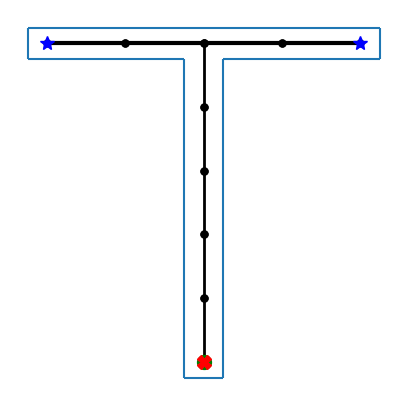

In [2]:
# Initialize the environment with default parameters
env = TMaze(2, 5)

# Render the maze and show the plot 
env.render()
plt.show()

Additionally to carrying out a comparison between TD algorithms with and without traces, you will also compare two different policies for action selection during training:

1. **$\mathbf{\epsilon}$-greedy policy**: given a state $s$ and a set of $Q$-values $Q$, the $\epsilon$-greedy policy chooses:

- with probability $1-\epsilon$ the action $a^{\star} = \mathrm{argmax}_{a}Q(s,a)$, where ties are broken randomly;
- with probability $\epsilon$ a uniformly chosen random action.

2. $\textbf{Softmax policy}$: given a state $s$ and a set of $Q$-values $Q$, it chooses the actions sampling from the probability distribution $\pi(\cdot\vert s)$ defined as
   $$
   \begin{equation}
   \pi(a\vert s) = \frac{\exp(\beta Q(s, a))}{\sum_{a'}\exp(\beta Q(s, a'))},
   \end{equation}
   $$
   where $\beta>0$ is the so-called scaling parameter.


#### Implement utilities for action selection


Implement two auxiliary functions in `algorithms_template.py`, called `epsilon_greedy` and `softmax_`, to perform action selection given a set of $Q$-values $Q$. _Hint: this function should return an available action given the current state of the environment_.


In [59]:
from RL_algorithms.algorithms_template import epsilon_greedy, softmax_

### Exercise 0: One step horizon


Start by considering a one step horizon reward scheme, i.e. the highest rewarded states are immediately reached after one step from the beginning. To do this, set $a = 1$ and $b = 0$ in the initialization of the environment.

Implement the $\text{Sarsa}$ algorithm in the `algorithms_template.py` file as you have seen it in the classroom.


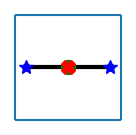

In [60]:
# Initialize the environment with default parameters
env = TMaze(1, 0)

# Render the maze and show the plot 
env.render()
plt.show()

In [ ]:
from RL_algorithms.algorithms_template import sarsa

Before running any further experiment, answer the following questions:

1. Assume the actions "left" and "right" are chosen alternatively and all $Q$-values are initialized at zero. For which learning rate $\alpha$ do you observe convergence of the $Q$-values in the minimum number of steps? Write down your calculations explicitly.
2. For a general policy, find a lower bound on the number of steps needed for convergence of the $Q$-values as a function of the learning rate $\alpha < 1$. In this case, by convergence we mean that both estimates of the $Q$-values should be at least $95 \%$ of their true values (e.g. the $Q$-value corresponding to going left should be at least 0.95 and the $Q$-value for going right should be at least 1.9). _Hint: use the fact that every episode only lasts 1 move and, starting from the update rule of Sarsa for the one-step horizon, write a recurrence relation for the update of the two $Q$-values. Then think of the worst case scenario to conclude._
3. Under an $\epsilon$-greedy policy, which value of $\epsilon$ will make training fail for sure?

Conclude the analysis you have done in Questions 1-3 by stating a couple $(\epsilon, \alpha)$ for which training 1 episode or training 100, 1000, ... episodes will give the same results over and over.

4. How does the use of a softmax policy change your answer to the question above? Which values of $\beta$ give an almost exploitatory action selection during training?

Verify your answers to the questions above numerically: test your implementation of Sarsa on the one step horizon environment and check convergence of the $Q$-values.

Additionally, feel free to test the influence of the learning rate $\alpha$ on the convergence of the $Q$-values.


In [ ]:
env = TMaze(1, 0)

###### GREEDY POLICY #########
print("============ GREEDY POLICY ==============")
alpha = 0.5  # alpha = 0.5 means at least 6 episodes
Q, stats = sarsa(env, num_episodes=5, epsilon_exploration=0, alpha=alpha) 
print("5 episodes ---> ", Q[(0, 0)])
Q, stats = sarsa(env, num_episodes=10, epsilon_exploration=0, alpha=alpha)
print("10 episodes ---> ", Q[(0, 0)])
Q, stats = sarsa(env, num_episodes=15, epsilon_exploration=0, alpha=alpha)
print("15 episodes ---> ", Q[(0, 0)])
Q, stats = sarsa(env, num_episodes=20, epsilon_exploration=0, alpha=alpha)
print("20 episodes ---> ", Q[(0, 0)])

###### 0.5 GREEDY POLICY #########
print("============ 0.5 GREEDY POLICY ==========")
alpha = 0.5  # alpha = 0.5 means at least 6 episodes
Q, stats = sarsa(env, num_episodes=5, epsilon_exploration=0.5, alpha=alpha) 
print("5 episodes ---> ", Q[(0, 0)])
Q, stats = sarsa(env, num_episodes=10, epsilon_exploration=0.5, alpha=alpha)
print("10 episodes ---> ", Q[(0, 0)])
Q, stats = sarsa(env, num_episodes=15, epsilon_exploration=0.5, alpha=alpha)
print("15 episodes ---> ", Q[(0, 0)])
Q, stats = sarsa(env, num_episodes=20, epsilon_exploration=0.5, alpha=alpha)
print("20 episodes ---> ", Q[(0, 0)])

###### EXPLORATORY SOFTMAX POLICY #########
print("============ EXPLORATORY SOFTMAX POLICY ==============")
alpha = 0.5  # alpha = 0.5 means at least 6 episodes
Q, stats = sarsa(env, num_episodes=5, action_policy='softmax_', epsilon_exploration=1, alpha=alpha) 
print("5 episodes ---> ", Q[(0, 0)])
Q, stats = sarsa(env, num_episodes=10, action_policy='softmax_', epsilon_exploration=1, alpha=alpha)
print("10 episodes ---> ", Q[(0, 0)])
Q, stats = sarsa(env, num_episodes=15, action_policy='softmax_', epsilon_exploration=1, alpha=alpha)
print("15 episodes ---> ", Q[(0, 0)])
Q, stats = sarsa(env, num_episodes=20, action_policy='softmax_', epsilon_exploration=1, alpha=alpha)
print("20 episodes ---> ", Q[(0, 0)])

###### EXPLOITATORY SOFTMAX POLICY #########
print("============ EXPLOITATORY SOFTMAX POLICY ==============")
alpha = 0.5  # alpha = 0.5 means at least 6 episodes
Q, stats = sarsa(env, num_episodes=5, action_policy='softmax_', epsilon_exploration=100, alpha=alpha) 
print("5 episodes ---> ", Q[(0, 0)])
Q, stats = sarsa(env, num_episodes=10, action_policy='softmax_', epsilon_exploration=100, alpha=alpha)
print("10 episodes ---> ", Q[(0, 0)])
Q, stats = sarsa(env, num_episodes=15, action_policy='softmax_', epsilon_exploration=100, alpha=alpha)
print("15 episodes ---> ", Q[(0, 0)])
Q, stats = sarsa(env, num_episodes=20, action_policy='softmax_', epsilon_exploration=100, alpha=alpha)
print("20 episodes ---> ", Q[(0, 0)])

### Exercise 1: Implementation of TD algorithms


In this exercise, you are asked to implement the Q-Learning($\lambda$), Sarsa($\lambda$) and $n$-step Sarsa algorithms in the cells below. To help you in the implementation, we guide you through the main steps of the implementation and ask you to fill in the missing parts accordingly to the hints in `algorithms_template.py`.

In order to understand fully how the available code works, we recommend you to have a look at the T Maze environment implementation in `environment1.py`.

$\texttt{Remark 1}$: In the upcoming weeks, you will be asked to repeat numerical experiments on other environments. In order to reuse the code you will develop in the cells below, make sure your implementation is general enough and works for any other environment derived from the abstract environment in `abstract_environment.py`.


#### Implementation of Q-Learning($\lambda$), Sarsa($\lambda$) and $n$-step Sarsa


Using the two auxiliary functions for action selection above, implement the $Q$-Learning($\lambda$), Sarsa($\lambda$) and $n$-step Sarsa algorithms. In the `algorithms_template.py` file you find some hints to guide you in the implementations.

Before implementing the algorithms, answer the following question:

1. For which value of $\lambda$ do you recover the standard versions of $Q$-Learning and Sarsa algorithms?

Make sure that your implementation recovers the standard algorithms for such a value of the trace decay parameter. For Sarsa, you may simply extend the code you delevoped above with proper changes (i.e. adding the possibility of a non-zero trace decay parameter).


In [ ]:
from RL_algorithms.algorithms_template import q_learning, sarsa, n_step_sarsa
env = TMaze(2,5)

#### Test your algorithms


Before moving on to further experiments, please test your implementation of the RL algorithms with the T-Maze environment.
To do so, you can use the provided helper function `play` in `utils_template.py`, which, given a set of _Q_-values, simulates the moves of the agent in the maze using a greedy policy (based on the given _Q_-values).


In [ ]:
from RL_algorithms.utils_template import play

Now, run the algorithms

1. $Q$-Learning($\lambda$) for $\lambda = 0$ and $\lambda \neq 0$,
2. Sarsa($\lambda$) for $\lambda = 0$ and $\lambda \neq 0$,
3. $n$-step Sarsa

that you implemented above for a sufficient number of episodes and, using the function you wrote in the previous cell, check that the agent learns to reach the highest rewarded state.

For the sake of convenience and in order to let you have a fair comparison of your results with your classmates, we recommend to set:

- the discount factor to $\gamma = 0.9$
- the trace decay factor in _Sarsa($\lambda$)_ and _Q-Learning($\lambda$)_ to $\lambda = 0.8$
- the number of steps for $n$-step Sarsa to $n = 3$
- the number of episodes played during learning to $n_{\mathrm{episodes}} = 200$
- the learning rate to $\alpha=0.1$
- the exploration parameter to $\epsilon=0.5$

For each of the $5$ algorithms you just tested, answer additionally the following questions:

1. Do you think the $Q$-values have converged? Why? Which $Q$-values are the most difficult to be updated and why? _Hint: For visualization of the learned Q-values, recall that you can type `env.render(Q)` with the obtained set of $Q$-values._
2. Has the policy converged?
3. Just based on these heatmaps of the $Q$-values, do you observe any difference in the use of $n$-step TD methods/TD methods with eligibility traces with respect to the standard TD methods.

Feel free to explore different hyperparameters' configurations for your own curiosity and to better understand their influence on the answers to the questions above.


In [ ]:
# Q-Learning(0)
Q, stats = q_learning(env, gamma=0.9, num_episodes=200, epsilon_exploration=0.5, alpha=0.1)
env.render(Q)
play(env, Q)

In [ ]:
# Sarsa(0)
Q, stats = sarsa(env, gamma=0.9, num_episodes=200, epsilon_exploration=0.5, alpha=0.1)
env.render(Q)
play(env, Q)

In [ ]:
# Q-Learning(\lambda)
Q, stats = q_learning(env, gamma=0.9, num_episodes=200, epsilon_exploration=0.5, alpha=0.1, trace_decay=0.8)
env.render(Q)
play(env, Q)

In [ ]:
# Sarsa(\lambda)
Q, stats = sarsa(env, gamma=0.9, num_episodes=200, epsilon_exploration=0.5, alpha=0.1, trace_decay=0.8)
env.render(Q)
play(env, Q)

In [ ]:
# n-step Sarsa
Q, stats = n_step_sarsa(env, gamma=0.9, num_episodes=200, epsilon_exploration=0.5, alpha=0.1, n=3)
env.render(Q)
play(env, Q)

### Exercise 2: Exploration-Exploitation dilemma


You are now going to explore different exploration strategies during training to see how learning is affected. To do this, let us assume an $\epsilon$-greedy policy for the action selection during training.

Answer the following questions **before** running any experiment:

1. Assume $\epsilon = 0$, i.e. the agent always chooses the best action available according to the current estimates of the $Q$-values. What is the problem of this kind of approach? Which part of the state-space will remain unexplored? _Hint: all $Q$-values are initialized at zero_.
2. What do you think can be the effect of the exploration parameter $\epsilon$ on the efficiency of learning?

Now, **verify experimentally** your results by using $Q$-Learning($\lambda = 0$) as training algorithm. For a fair comparison with your classmates, set:

- the discount factor to $\gamma = 0.9$
- the number of episodes played during learning to $n_{\mathrm{episodes}} = 200$
- the learning rate to $\alpha=0.1$

Test the values $\epsilon = 0, 0.2, 0.5, 0.8, 1$ using the functions provided in `utils_template.py`. Are the numerical results you observe in line with what you expected? Which value of $\epsilon$ is the best one in your opinion?

Additionally, you can test for your own curiosity the convergence of the $Q$-values to their true value (using `env.render(Q)`) for different values of $\epsilon$.


In [ ]:
from RL_algorithms.utils_template import *

# Hyperparameters
gamma = 0.9
alpha = 0.1
num_avg = 30

params = {
    'gamma' : gamma,
    'alpha' : alpha,
    'action_policy': "epsilon_greedy"
}

Q_LEARNING_GREEDY = {
    'algo_name': 'q_learning',
    'name': r'$\epsilon = 0$',
    'params': {**params, 'epsilon_exploration': 0}
}

Q_LEARNING_20_PERCENT_GREEDY = {
    'algo_name': 'q_learning',
    'name': r'$\epsilon = 0.2$',
    'params': {**params, 'epsilon_exploration': 0.2}
}

Q_LEARNING_50_PERCENT_GREEDY = {
    'algo_name': 'q_learning',
    'name': r'$\epsilon = 0.5$',
    'params': {**params, 'epsilon_exploration': 0.5}
}

Q_LEARNING_80_PERCENT_GREEDY = {
    'algo_name': 'q_learning',
    'name': r'$\epsilon = 0.8$',
    'params': {**params, 'epsilon_exploration': 0.8}
}

Q_LEARNING_RANDOM = {
    'algo_name': 'q_learning',
    'name': r'$\epsilon = 1$',
    'params': {**params, 'epsilon_exploration': 1}
}


algorithms = [Q_LEARNING_GREEDY, Q_LEARNING_20_PERCENT_GREEDY, Q_LEARNING_50_PERCENT_GREEDY,
              Q_LEARNING_80_PERCENT_GREEDY, Q_LEARNING_RANDOM]

env = TMaze(2, 5)
compare_episodes_lengths_and_rewards(env=env, algos=algorithms, num_avg=num_avg,
                                     show_std=True, additional_params=[{"num_episodes": 200}] * len(algorithms))

Assume now instead a softmax policy for action selection. Under this policy, each action has a non-zero probability to be selected. Moreover, exploration is controlled by the scaling parameter $\beta$.

Answer the following question **before** running any experiment:

1. Which values of $\beta$ should guarantee a better exploration during training? Which values guarantee, instead, an almost greedy policy?
2. What do you think can be the effect of $\beta$ on the performance? Why?

Set $\beta = 0.1, 1, 5, 10, 100$ and repeat the experiments you carried out before. Are the numerical results you observe in line with what you expected? Which value of $\beta$ is the best in your opinion?

Additionally, you can test for your own curiosity the convergence of the $Q$-values to their true value (using `env.render(Q)`) for different values of $\beta$.


In [ ]:
from RL_algorithms.utils_template import *

# Hyperparameters
gamma = 0.9
alpha = 0.1
num_avg = 30

params = {
    'gamma' : gamma,
    'alpha' : alpha,
    'action_policy': 'softmax_'
}

Q_LEARNING_NON_GREEDY = {
    'algo_name': 'q_learning',
    'name': r'$\beta = 0.1$',
    'params': {**params, 'epsilon_exploration': 0.1}
}

Q_LEARNING_1_GREEDY = {
    'algo_name': 'q_learning',
    'name': r'$\beta = 1$',
    'params': {**params, 'epsilon_exploration': 1}
}

Q_LEARNING_5_GREEDY = {
    'algo_name': 'q_learning',
    'name': r'$\beta = 5$',
    'params': {**params, 'epsilon_exploration': 5}
}

Q_LEARNING_10_GREEDY = {
    'algo_name': 'q_learning',
    'name': r'$\beta = 10$',
    'params': {**params, 'epsilon_exploration': 10}
}

Q_LEARNING_100_GREEDY = {
    'algo_name': 'q_learning',
    'name': r'$\beta = 100$',
    'params': {**params, 'epsilon_exploration': 100}
}



algorithms = [Q_LEARNING_NON_GREEDY, Q_LEARNING_1_GREEDY, Q_LEARNING_5_GREEDY, Q_LEARNING_10_GREEDY, Q_LEARNING_100_GREEDY]

env = TMaze(2, 5)
compare_episodes_lengths_and_rewards(env=env, algos=algorithms, num_avg=num_avg,
                                     show_std=True, additional_params=[{"num_episodes": 200}] * len(algorithms))

### Exercise 3: Comparison of RL algorithms for different discretization schemes


As stated in the [introduction](introduction), the main goal of this computational exercise session is to understand how the coupling of TD algorithms with eligibility traces can provide benefits for the learning of an agent with respect to the case $\lambda = 0$.

To this aim, we consider a discretization of the T-Maze with 6, 11, 20 states and test the performance of different RL algorithms on these environments.

Answer these questions **before** running any experiments:

1. Consider the case in which the agent is trained with $\lambda = 0$ on a T-Maze($a, b$). How many episodes are necessary to propagate back the reward information from the goal states to the origin? _Hint: all $Q$-values are initialized at zero._
2. Does your answer change if $\lambda \neq 0$?

Now, consider the following hyperparameter configuration:

- the discount factor to $\gamma = 0.9$
- the trace decay factor in _Sarsa($\lambda$)_ and _Q-Learning($\lambda$)_ to $\lambda = 0.8$
- the number of episodes played during learning to $n_{\mathrm{episodes}} = 50$
- the learning rate to $\alpha=0.1$
- the exploration parameter $\epsilon$ to the best value according to your experiments in Exercise 2.

**Verify experimentally** your answers to the questions above. Again, to do so you may use the functions provided in `utils_template.py`. What are you observing? Answer the questions below.

1. Is the performance of the $Q$-Learning and Sarsa independent of the discretization?
2. What happens instead for $Q$-Learning($\lambda$) and Sarsa($\lambda$)? Can you claim undeniably that the performance is independent of the discretization scheme? _Hint: In the experiments above, $\lambda$ is kept fixed for the sake of simplicity; but can we choose a more meaningful scheme?._


In [ ]:
from RL_algorithms.utils_template import *

# Hyperparameters
epsilon_exploration = None   # CHANGE TO YOUR BEST VALUE
gamma = 0.9
alpha = 0.1
trace_decay = 0.8
num_avg = 30

params = {
    'epsilon_exploration' : epsilon_exploration,
    'gamma' : gamma,
    'alpha' : alpha,
}

Q_LEARNING = {
    'algo_name': 'q_learning',
    'name': 'Q-Learning(0)',
    'params': params,
}

Q_LEARNING_LAMBDA = {
    'algo_name': 'q_learning',
    'name': 'Q-Learning($\lambda$)',
    'params': {**params, 'trace_decay': trace_decay}
}

SARSA = {
    'algo_name': 'sarsa',
    'name': 'Sarsa(0)',
    'params': params
}

SARSA_LAMBDA = {
    'algo_name': 'sarsa',
    'name': 'Sarsa($\lambda$)',
    'params': {**params, 'trace_decay': trace_decay}
}

THREE_STEP_SARSA = {
    'algo_name': 'n_step_sarsa',
    'name': '3-step Sarsa',
    'params': {**params, 'n': 3}
}

algorithms = [Q_LEARNING, Q_LEARNING_LAMBDA, SARSA, SARSA_LAMBDA, THREE_STEP_SARSA]

couples = ((1, 3), (2, 6), (3, 13))
for j, couple in enumerate(couples):
    env = TMaze(*couple)
    compare_episodes_lengths_and_rewards(env=env, algos=algorithms, num_avg=num_avg,
                                         show_std=True, additional_params=[{"num_episodes": 50}] * len(algorithms))

### Exercise 4: Rescaling of the trace decay and step parameters


Answer the following questions **before** running any experiment:

Consider a T-Maze environment with $s$ states separating the starting state from each of the goal states, i.e $s = a+b$.

1. How should you rescale the number of steps used for the $n$-step Sarsa algorithm to have a similar performance if $s$ is doubled, i.e. $s \gets 2s$?

**Verify experimentally** your results by looking again at the running average of the reward and at the episode lengths during training.


In [ ]:
# Hyperparameters
epsilon_exploration = None   # CHANGE TO YOUR BEST VALUE
gamma = 0.9
alpha = 0.1
num_avg = 30

params = {
    'epsilon_exploration' : epsilon_exploration,
    'gamma' : gamma,
    'alpha' : alpha,
    'num_episodes': 50
}

ONE_STEP_SARSA = {
    'algo_name': 'n_step_sarsa',
    'name': '1-step Sarsa',
    'params': {**params, 'n': 1}
}

TWO_STEP_SARSA = {
    'algo_name': 'n_step_sarsa',
    'name': '2-step Sarsa',
    'params': {**params, 'n': 2}
}

FOUR_STEP_SARSA = {
    'algo_name': 'n_step_sarsa',
    'name': '4-step Sarsa',
    'params': {**params, 'n': 4}
}

EIGHT_STEP_SARSA = {
    'algo_name': 'n_step_sarsa',
    'name': '8-step Sarsa',
    'params': {**params, 'n': 8}
}

SIXTEEN_STEP_SARSA = {
    'algo_name': 'n_step_sarsa',
    'name': '16-step Sarsa',
    'params': {**params, 'n': 16}
}

algorithms = {'0': [ONE_STEP_SARSA, TWO_STEP_SARSA, FOUR_STEP_SARSA],
              '1': [TWO_STEP_SARSA, FOUR_STEP_SARSA, EIGHT_STEP_SARSA],
              '2': [FOUR_STEP_SARSA, EIGHT_STEP_SARSA, SIXTEEN_STEP_SARSA]}

couples = ((2, 5), (4, 10), (8, 20))

for j, couple in enumerate(couples):
    env = TMaze(*couple)
    compare_episodes_lengths_and_rewards(env=env, algos=algorithms[str(j)], num_avg=num_avg,
                                         show_std=True, additional_params=[{"num_episodes": 50}] * len(algorithms))